# 1. Load và kiểm tra dữ liệu:

In [9]:
import re
import statistics as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

In [10]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Liên kết drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

Using Colab cache for faster access to the 'hate-speech-and-offensive-language-dataset' dataset.
Path to dataset files: /kaggle/input/hate-speech-and-offensive-language-dataset
Files in dataset directory: ['labeled_data.csv']


In [14]:
# Đọc và kiểm tra dữ liệu:
from IPython.display import display
data = pd.read_csv(path + '/labeled_data.csv')
print("dataset head:")
display(data.head())
print("dataset info:")
data.info()

dataset head:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [15]:
# Làm sạch dữ liệu và chuẩn hóa nhãn:
data_cleaned = data.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns = {'class':'label'}, inplace=True)

label_mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label'] = data_cleaned['label'].map(label_mapping)

print("Cleaned dataset head:")
print(data_cleaned.head())
print("Cleaned dataset info:")
data_cleaned.info()
print("Value counts for labels:")
print(data_cleaned['label'].value_counts())

Cleaned dataset head:
                label                                              tweet
0             neither  !!! RT @mayasolovely: As a woman you shouldn't...
1  offensive_language  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2  offensive_language  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3  offensive_language  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4  offensive_language  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  object
 1   tweet   24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB
Value counts for labels:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


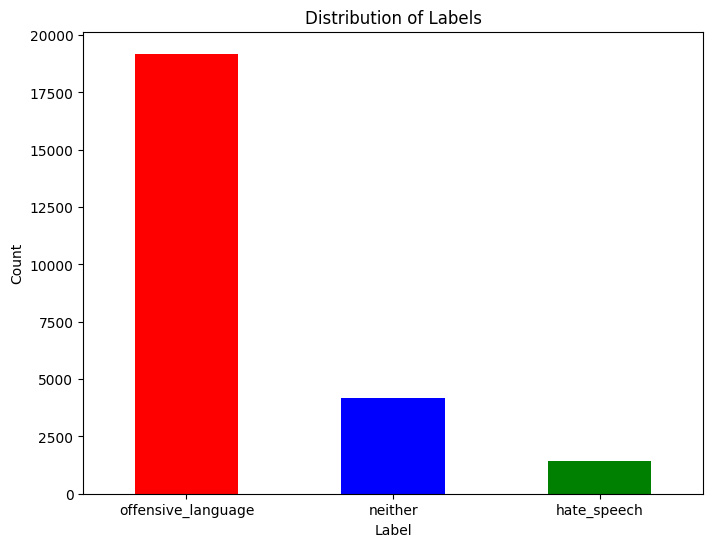

In [16]:
# Trực quan hóa phân bố nhãn:
plt.figure(figsize=(8,6))
data_cleaned['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# 2. Tiền xử lý dữ liệu:

## 2.1. Tiền xử lý dữ liệu:

Dữ liệu tweet thường chứa nhiều thành phần gây nhiễu (URL, mention, hashtag, ký tự đặc biệt).
Bước này chuẩn hóa văn bản để mô hình tập trung vào nội dung chính.

Các thao tác được áp dụng:

- Loại bỏ URL (link)
- Loại bỏ mention (ví dụ: @username)
- Loại bỏ hashtag (ví dụ: #topic)
- Chuyển toàn bộ về chữ thường (lowercase)
- Tokenize văn bản thành các từ
- Lọc chỉ giữ token là chữ cái và loại bỏ stopwords tiếng Anh
- Ghép token trở lại thành chuỗi để đưa vào pipeline huấn luyện
- Kết quả mong đợi: cột tweet đã được làm sạch và đồng nhất định dạng trước khi đưa vào mô hình.

In [17]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)

print('Data after cleaning:')
print(data_cleaned.head())

Data after cleaning:
                label                                              tweet
0             neither  rt woman complain cleaning house amp man alway...
1  offensive_language  rt boy dats cold tyga dwn bad cuffin dat hoe p...
2  offensive_language  rt dawg rt ever fuck bitch start cry confused ...
3  offensive_language                                rt look like tranny
4  offensive_language  rt shit hear might true might faker bitch told ya


In [19]:
label_to_int_map = {'hate_speech': 0, 'offensive_language': 1, 'neither': 2}
int_to_label_map = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label_int'] = data_cleaned['label'].map(label_to_int_map) # Apply to data_cleaned
class_names = [int_to_label_map[i] for i in sorted(int_to_label_map.keys())]
print("Updated data_cleaned with integer labels and defined class_names:", class_names)

Updated data_cleaned with integer labels and defined class_names: ['hate_speech', 'offensive_language', 'neither']


- Chia train, val, test theo tỉ lệ 8:1:1:

In [20]:
# Split data_cleaned into train, validation, and test sets FIRST
train_df, temp_df = train_test_split(
    data_cleaned, test_size=0.2, stratify=data_cleaned['label_int'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label_int'], random_state=42
)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# These will be updated after augmentation and balancing of the training set
# X_train and y_train will be finalized in the balancing cell.
X_val = val_df['tweet'].values
y_val = val_df['label_int'].values
X_test = test_df['tweet'].values
y_test = test_df['label_int'].values

Train samples: 19826
Validation samples: 2478
Test samples: 2479


## 2.2. Data augmentation:

- Tăng cường dữ liệu cho lớp có ít mẫu (chỉ làm trên tập train):

Train data after augmentation (before balancing):
label
offensive_language    15352
hate_speech            4564
neither                3330
Name: count, dtype: int64


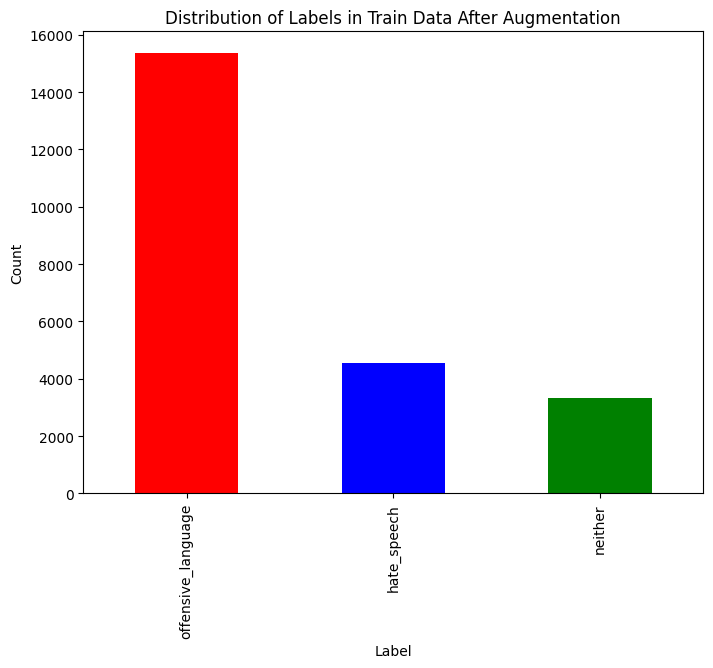

In [21]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text(text, num_augments=1):
    word = text.split()
    augment_text = []

    for i in range(num_augments):
        new_words = list(word)

        if not new_words:
            continue

        random_word_index = np.random.randint(0, len(new_words))
        random_word = new_words[random_word_index]

        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = np.random.choice(synonyms)
            new_words[random_word_index] = random_synonym

        augment_text.append(' '.join(new_words))
    return augment_text

hate_speech_train = train_df[train_df['label'] == 'hate_speech'].copy()

# Augment 'hate_speech' class in training data
augment_samples_train = []
for index, row in hate_speech_train.iterrows():
    augmented_texts  = augment_text(row['tweet'], num_augments=3)
    for aug_text in augmented_texts :
        augment_samples_train.append({'tweet': aug_text, 'label': 'hate_speech', 'label_int': label_to_int_map['hate_speech']})

augmented_hate_speech_train_df = pd.DataFrame(augment_samples_train)

# Concatenate augmented hate speech samples with the original training dataframe
train_df_augmented = pd.concat([train_df, augmented_hate_speech_train_df], ignore_index=True)

print("Train data after augmentation (before balancing):")
print(train_df_augmented['label'].value_counts())
plt.figure(figsize=(8,6))
train_df_augmented['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Train Data After Augmentation')
plt.show()

- Cân bằng dữ liệu theo số lượng mẫu giữa các lớp:

Target count for balancing training data: 15352

Final training class distribution:
label
hate_speech           15352
neither               15352
offensive_language    15352
Name: count, dtype: int64


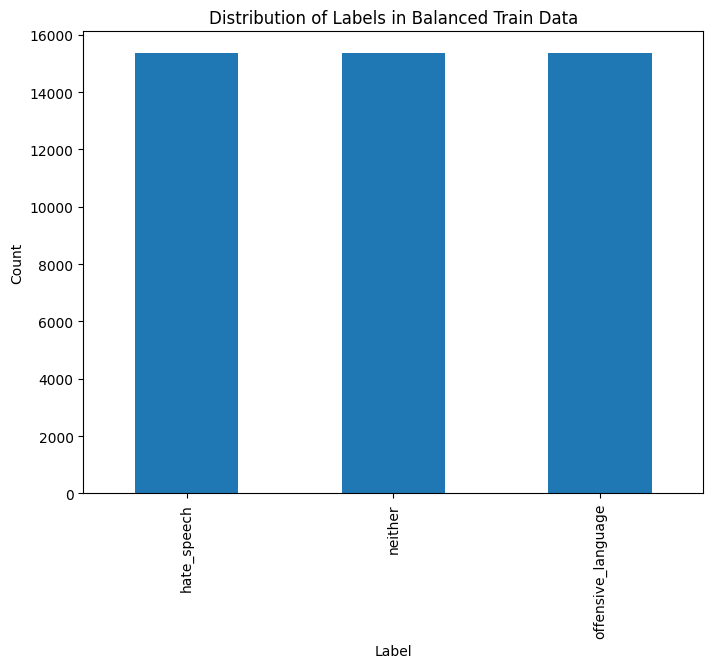

Total training samples: 46056
         label                                              tweet  label_int
0  hate_speech  michael sam cut proves fags go football hetero...          0
1  hate_speech                       people endure unwashed trash          0
2      neither                 rt got reception ink soles problem          2
3      neither                             would cripple military          2
4  hate_speech  means im following arrange subordinate action ...          0


In [22]:
# 1) Tách theo label dạng chuỗi - ONLY ON TRAINING DATA
df_hate_train   = train_df_augmented[train_df_augmented['label'] == 'hate_speech'].copy()
df_off_train    = train_df_augmented[train_df_augmented['label'] == 'offensive_language'].copy()
df_nei_train    = train_df_augmented[train_df_augmented['label'] == 'neither'].copy()

# 2) Target = lớp nhiều nhất trong TRAIN data
target_count_train = max(len(df_hate_train), len(df_off_train), len(df_nei_train))
print("Target count for balancing training data:", target_count_train)

def augment_to_target(df_class, target):
    # Nếu đã >= target thì downsample về đúng target
    if len(df_class) >= target:
        return df_class.sample(n=target, replace=False, random_state=42)

    # Nếu thiếu thì oversample + augment
    need = target - len(df_class)
    seeds = df_class.sample(n=need, replace=True, random_state=42)

    augmented_rows = []
    for _, row in seeds.iterrows():
        # tạo 1 câu mới
        new_text = augment_text(row['tweet'], num_augments=1)
        new_text = new_text[0] if new_text else row['tweet']  # phòng trường hợp rỗng

        augmented_rows.append({
            'tweet': new_text,
            'label': row['label'],
            'label_int': row['label_int'] # Keep the integer label consistent
        })

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df_class, augmented_df], ignore_index=True)

balanced_hate_train = augment_to_target(df_hate_train, target_count_train)
balanced_nei_train  = augment_to_target(df_nei_train, target_count_train)

# 3) Ghép lại training dataset cân bằng (giữ offensive nguyên)
data_balanced_train = pd.concat([df_off_train, balanced_hate_train, balanced_nei_train], ignore_index=True)

# 4) Shuffle training data
data_balanced_train = data_balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nFinal training class distribution:")
print(data_balanced_train['label'].value_counts())

plt.figure(figsize=(8,6))
data_balanced_train['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Balanced Train Data')
plt.show()

print("Total training samples:", len(data_balanced_train))
print(data_balanced_train.head())

# Assign X_train and y_train from the balanced training data
X_train = data_balanced_train['tweet'].values
y_train = data_balanced_train['label_int'].values

# X_val, y_val, X_test, y_test are already defined from the initial split

# 2. Mô hình RNN cơ bản:

In [23]:
# Import các thư viện cần thiết:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## 2.1. Tiền xử lý dữ liệu:

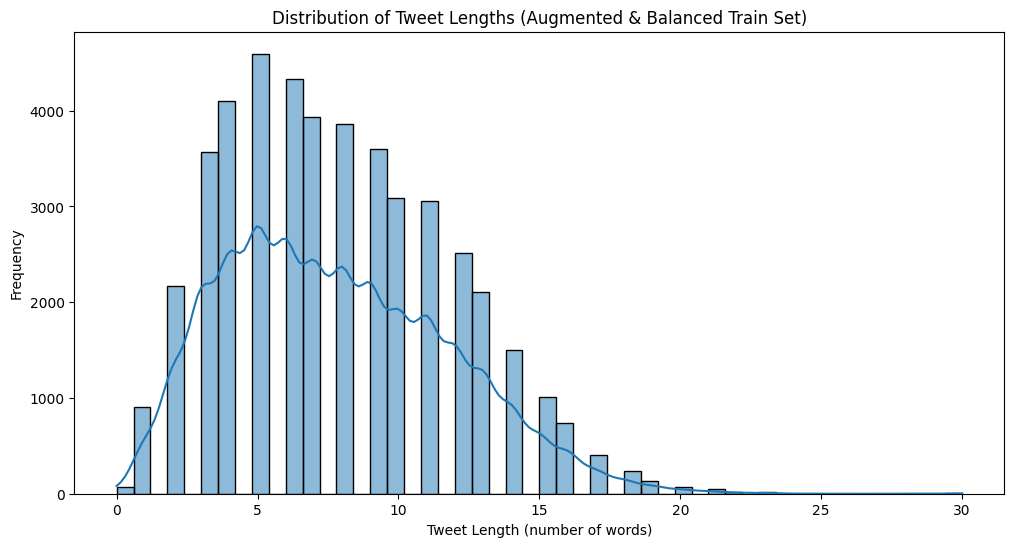

count    46056.000000
mean         7.793990
std          3.980796
min          0.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         30.000000
Name: tweet_length, dtype: float64


In [24]:
# Khảo sát độ dài chuỗi sau khi clean (dựa trên tập train đã qua augmentation và balancing):
data_balanced_train['tweet_length'] = data_balanced_train['tweet'].apply(lambda x: len(x.split()))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data_balanced_train['tweet_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths (Augmented & Balanced Train Set)')
plt.xlabel('Tweet Length (number of words)')
plt.ylabel('Frequency')
plt.show()

print(data_balanced_train['tweet_length'].describe())

In [25]:
# Tokenization và padding tối ưu:
# Define tokenizer and MAX_VOCAB/MAX_LEN based on the augmented and balanced X_train
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # Fit only on the (augmented and balanced) training data

MAX_VOCAB = min(len(tokenizer.word_index) + 1, 20000)
MAX_LEN = int(data_balanced_train['tweet_length'].describe()['75%']) + 5 # Use 75th percentile + 5 for robustness

print(f"Updated MAX_VOCAB: {MAX_VOCAB}")
print(f"Updated MAX_LEN: {MAX_LEN}")

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # Re-fit with num_words limit

def encode(texts):
    return pad_sequences(
        tokenizer.texts_to_sequences(texts),
        maxlen=MAX_LEN,
        padding='post',
        truncating='post'
    )

X_train_seq = encode(X_train)
X_val_seq   = encode(X_val)
X_test_seq  = encode(X_test)

print("Tokenization and padding updated successfully with new MAX_VOCAB and MAX_LEN.")

Updated MAX_VOCAB: 19760
Updated MAX_LEN: 16
Tokenization and padding updated successfully with new MAX_VOCAB and MAX_LEN.


## 2.2. Load GloVe Twitter Embedding:

In [26]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

EMB_DIM = 100
embedding_index = {}

with open("glove.twitter.27B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((MAX_VOCAB, EMB_DIM))

for word, idx in tokenizer.word_index.items():
    if idx < MAX_VOCAB:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

--2025-12-28 13:54:34--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-12-28 13:54:34--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-12-28 13:54:34--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

## 2.3. Xây dựng mô hình RNN đơn giản:

In [27]:
model_rnn = Sequential([
    Embedding(
        input_dim=MAX_VOCAB,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),

    SimpleRNN(
        128,
        activation='tanh',
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.2
    ),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 2.4. Compile và train mô hình lần 1:

In [28]:
# Compile model:
optimizer = Adam(
    learning_rate=1e-3,
    clipnorm=1.0   # CỰC QUAN TRỌNG cho RNN
)

model_rnn.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,976,000 (7.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,976,000 (7.54 MB)

In [29]:
# Callbacks:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs',
        histogram_freq=1
    )
]

In [30]:
# Train mô hình:
history = model_rnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5047 - loss: 0.9795

720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5047 - loss: 0.9794 - val_accuracy: 0.8176 - val_loss: 0.7550 - learning_rate: 0.0010
Epoch 2/30
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6022 - loss: 0.8457

720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6023 - loss: 0.8456 - val_accuracy: 0.8241 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 3/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6653 - loss: 0.7914

720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6653 - loss: 0.7914 - val_accuracy: 0.8333 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 4/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6735 - loss: 0.7754 - val_accuracy: 0.8394 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 5/30
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6937 - loss: 0.7464

720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6937 - loss: 0.7463 - val_accuracy: 0.8188 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 6/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7015 - loss: 0.7266 - val_accuracy: 0.8345 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 7/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7102 - loss: 0.7134 - val_accuracy: 0.8059 - val_loss: 0.5088 - learning_rate: 0.0010
Epoch 8/30
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7136 - loss: 0.7036

720/720 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7136 - loss: 0.7036 - val_accuracy: 0.8349 - val_loss: 0.4960 - learning_rate: 0.0010
Epoch 9/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7147 - loss: 0.6969 - val_accuracy: 0.8398 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 10/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7206 - loss: 0.6876 - val_accuracy: 0.8394 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 11/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7340 - loss: 0.6691 - val_accuracy: 0.8438 - val_loss: 0.5076 - learning_rate: 0.0010
Epoch 12/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7296 - loss: 0.6685 - val_accuracy: 0.8192 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 13/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7363 - loss: 0.6642 - val_accuracy: 0.8236 - val_loss: 0.5657 - learning_rate: 0.0010
Epoch 14/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - loss: 0.6575

720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7386 - loss: 0.6574 - val_accuracy: 0.8386 - val_loss: 0.4622 - learning_rate: 5.0000e-04
Epoch 15/30
716/720 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7473 - loss: 0.6450

720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7473 - loss: 0.6450 - val_accuracy: 0.8475 - val_loss: 0.4519 - learning_rate: 5.0000e-04
Epoch 16/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7441 - loss: 0.6509 - val_accuracy: 0.8345 - val_loss: 0.4935 - learning_rate: 5.0000e-04
Epoch 17/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7507 - loss: 0.6334 - val_accuracy: 0.8378 - val_loss: 0.4841 - learning_rate: 5.0000e-04
Epoch 18/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7532 - loss: 0.6250 - val_accuracy: 0.8511 - val_loss: 0.4644 - learning_rate: 5.0000e-04
Epoch 19/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7572 - loss: 0.6199 - val_accuracy: 0.8442 - val_loss: 0.4548 - learning_rate: 5.0000e-04
Epoch 20/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7532 - loss: 0.6246 - val_accuracy: 0.8394 - val_loss: 0.5202 - learning_rate: 5.0000e-04
Epoch 21/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.755

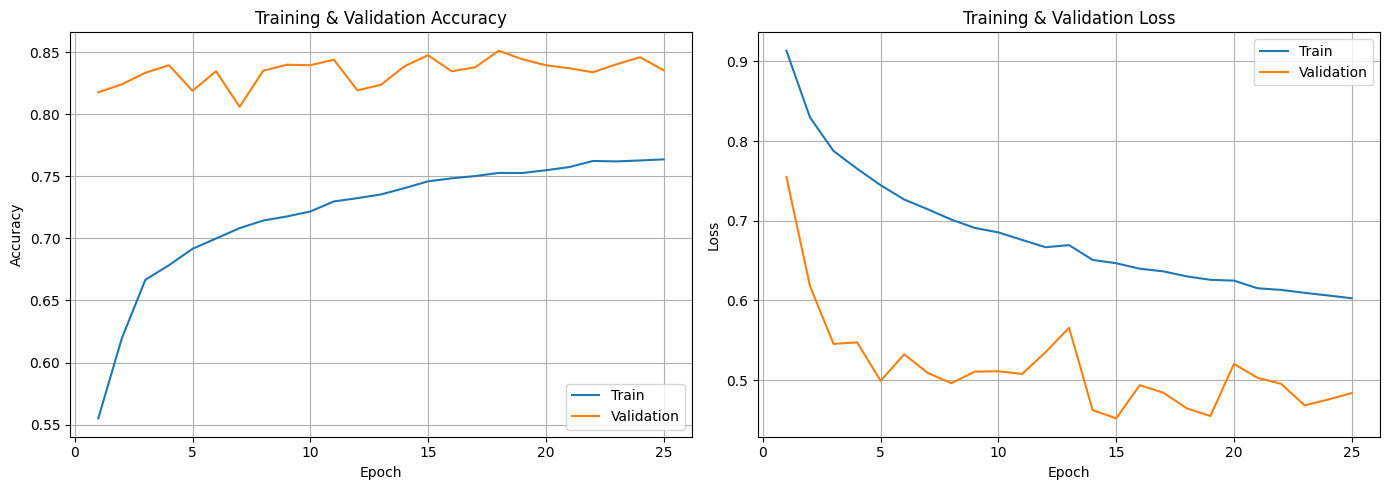

In [31]:
# In ra quá trình huấn luyện:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend(["Train", "Validation"])
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend(["Train", "Validation"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


## 2.5. Mở khối embedding và train thêm lần 2:

In [32]:
# Mở embedding:
model_rnn.layers[0].trainable = True

In [33]:
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,   # GIẢM LR
        clipnorm=1.0
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Train lần 2:
history_finetune = model_rnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7528 - loss: 0.6272 - val_accuracy: 0.8434 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7593 - loss: 0.6150 - val_accuracy: 0.8491 - val_loss: 0.4533 - learning_rate: 1.0000e-04
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7649 - loss: 0.6047 - val_accuracy: 0.8370 - val_loss: 0.4723 - learning_rate: 1.0000e-04
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7713 - loss: 0.5900 - val_accuracy: 0.8422 - val_loss: 0.4678 - learning_rate: 1.0000e-04
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7801 - loss: 0.5716 - val_accuracy: 0.8426 - val_loss: 0.4639 - learning_rate: 1.0000e-04
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7811 - loss: 0.5700 - val_accuracy: 0.8362 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accurac

720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7944 - loss: 0.5380 - val_accuracy: 0.8479 - val_loss: 0.4506 - learning_rate: 5.0000e-05
Epoch 12/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8008 - loss: 0.5328 - val_accuracy: 0.8430 - val_loss: 0.4518 - learning_rate: 5.0000e-05
Epoch 13/20
718/720 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8028 - loss: 0.5273

720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8028 - loss: 0.5273 - val_accuracy: 0.8491 - val_loss: 0.4455 - learning_rate: 5.0000e-05
Epoch 14/20
717/720 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8059 - loss: 0.5242

720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8059 - loss: 0.5242 - val_accuracy: 0.8555 - val_loss: 0.4357 - learning_rate: 5.0000e-05
Epoch 15/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8058 - loss: 0.5142 - val_accuracy: 0.8523 - val_loss: 0.4415 - learning_rate: 5.0000e-05
Epoch 16/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8092 - loss: 0.5092 - val_accuracy: 0.8479 - val_loss: 0.4481 - learning_rate: 5.0000e-05
Epoch 17/20
719/720 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8132 - loss: 0.5063

720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8132 - loss: 0.5063 - val_accuracy: 0.8539 - val_loss: 0.4341 - learning_rate: 5.0000e-05
Epoch 18/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8179 - loss: 0.4970 - val_accuracy: 0.8507 - val_loss: 0.4478 - learning_rate: 5.0000e-05
Epoch 19/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8172 - loss: 0.4962 - val_accuracy: 0.8471 - val_loss: 0.4446 - learning_rate: 5.0000e-05
Epoch 20/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8187 - loss: 0.4958 - val_accuracy: 0.8515 - val_loss: 0.4404 - learning_rate: 5.0000e-05


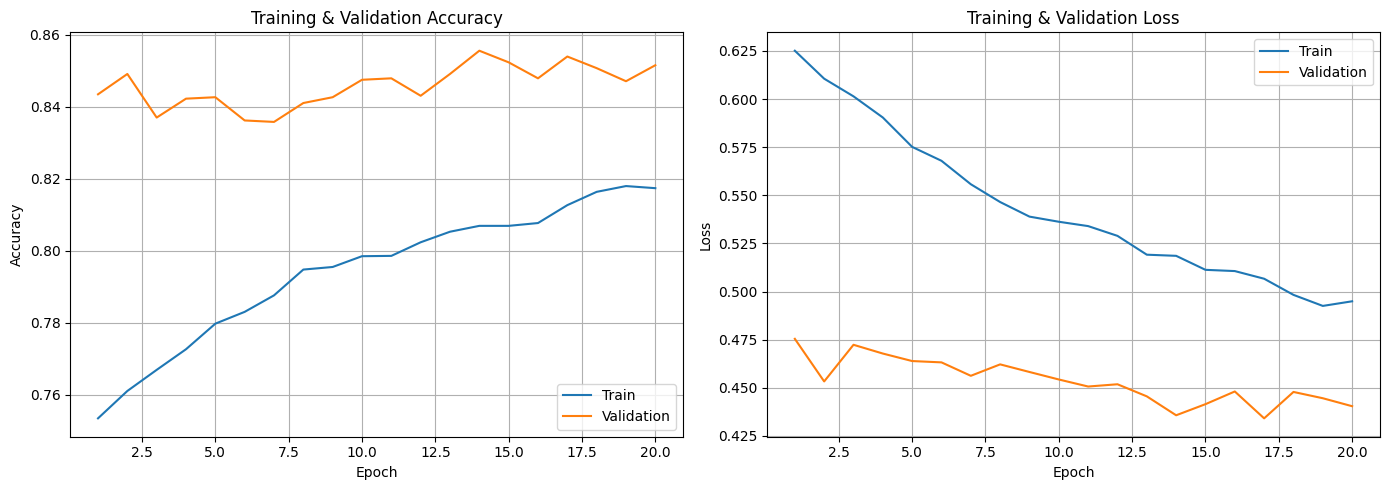

In [35]:
# In ra quá trình huấn luyện:
plot_training_history(history_finetune)

## 2.6. Đánh giá mô hình trên tập test:

In [36]:
# Test mô hình:
y_pred = np.argmax(model_rnn.predict(X_test_seq), axis=1)

print(classification_report(y_test, y_pred, target_names=[
    "Hate Speech", "Offensive", "Neither"
]))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

 Hate Speech       0.27      0.56      0.37       143
   Offensive       0.97      0.86      0.91      1919
     Neither       0.80      0.91      0.85       417

    accuracy                           0.85      2479
   macro avg       0.68      0.78      0.71      2479
weighted avg       0.90      0.85      0.87      2479



In [37]:
report = classification_report(
    y_test,
    y_pred,
    target_names=class_names,
    digits=4
)

print(report)

                    precision    recall  f1-score   support

       hate_speech     0.2730    0.5594    0.3670       143
offensive_language     0.9667    0.8614    0.9110      1919
           neither     0.8004    0.9137    0.8533       417

          accuracy                         0.8528      2479
         macro avg     0.6800    0.7782    0.7104      2479
      weighted avg     0.8987    0.8528    0.8699      2479



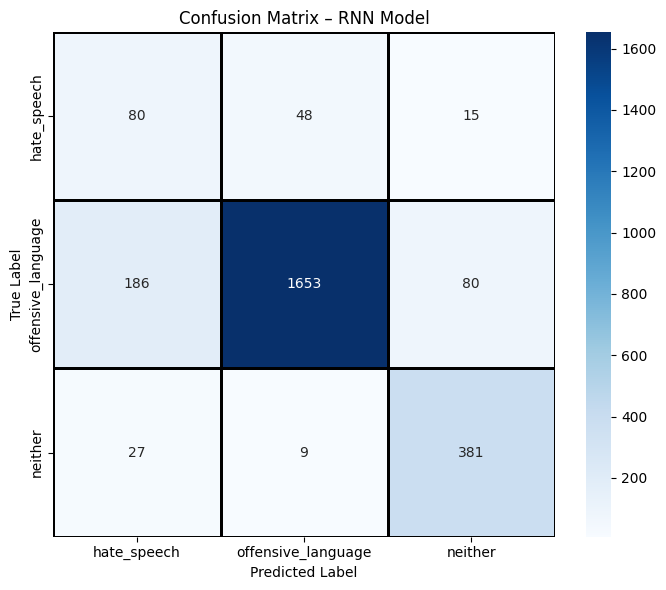

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,
    linecolor="black"
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – RNN Model")
plt.tight_layout()
plt.show()

## 2.6. Lưu mô hình về drive:

In [39]:
# Lưu mô hình về drive:
import os
SAVE_DIR = "/content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/RNN_model"
os.makedirs(SAVE_DIR, exist_ok=True)

rnn_model_path = os.path.join(SAVE_DIR, "rnn_hate_speech.keras")
model_rnn.save(rnn_model_path)
print(f"✅ RNN model saved to: {rnn_model_path}")

✅ RNN model saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/RNN_model/rnn_hate_speech.keras


In [40]:
# Lưu tokenizer:
import pickle

tokenizer_path = os.path.join(SAVE_DIR, "tokenizer_rnn.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"✅ Tokenizer saved to: {tokenizer_path}")

✅ Tokenizer saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/RNN_model/tokenizer_rnn.pkl


In [41]:
# Lưu config preprocessing:
import json

config = {
    "MAX_LEN": MAX_LEN,
    "MAX_VOCAB": MAX_VOCAB,
    "LABEL_MAPPING": {
        "0": "Hate Speech",
        "1": "Offensive",
        "2": "Neither"
    }
}

config_path = os.path.join(SAVE_DIR, "config_rnn.json")

with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print(f"✅ Config saved to: {config_path}")

✅ Config saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/RNN_model/config_rnn.json


In [42]:
# Test lại model đã lưu:
from tensorflow.keras.models import load_model

loaded_rnn = load_model(rnn_model_path)

loaded_rnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 16, 100)        │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,027,528 (15.36 MB)

 Trainable params: 2,013,763 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,013,765 (7.68 MB)

In [43]:
sample_text = ["you are a stupid, an idiot, a cow in a small circle"]

sample_clean = [clean_text(sample_text[0])]
sample_seq = encode(sample_clean)

pred = loaded_rnn.predict(sample_seq)
pred_label = np.argmax(pred, axis=1)[0]

print("Prediction:", config["LABEL_MAPPING"][str(pred_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
Prediction: Hate Speech


# 3. Mô hình LSTM 1 chiều:

## 3.1. Tiền xử lý dữ liệu:

Ta giữ nguyên dữ liệu đã tiền xử lý cho RNN, áp dụng luôn cho LSTM một chiều để giữ tính công bằng.

In [44]:
# Kiểm tra lại dữ liệu đầu vào:
print("Shapes: ", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Train label distribution:", np.unique(y_train, return_counts=True))
print("Validation label distribution:", np.unique(y_val, return_counts=True))
print("Test label distribution:", np.unique(y_test, return_counts=True))

Shapes:  (46056, 16) (2478, 16) (2479, 16)
Train label distribution: (array([0, 1, 2]), array([15352, 15352, 15352]))
Validation label distribution: (array([0, 1, 2]), array([ 143, 1919,  416]))
Test label distribution: (array([0, 1, 2]), array([ 143, 1919,  417]))


## 3.2. Xây dựng mô hình LSTM một chiều:

In [45]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout

In [46]:
model_lstm = Sequential([
    Embedding(
        input_dim=MAX_VOCAB,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),

    LSTM(
        128,
        return_sequences=False,
        dropout=0.3,
        recurrent_dropout=0.2
    ),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 3.3. Huấn luyện mô hình với cấu hình cũ:

In [47]:
# Compile model:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0
)

model_lstm.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,976,000 (7.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,976,000 (7.54 MB)

In [48]:
# Train mô hình LSTM giai đoạn 1:
history_lstm = model_lstm.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6705 - loss: 0.7390

720/720 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - accuracy: 0.6706 - loss: 0.7389 - val_accuracy: 0.8592 - val_loss: 0.3795 - learning_rate: 0.0010
Epoch 2/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.7961 - loss: 0.5136 - val_accuracy: 0.8374 - val_loss: 0.4371 - learning_rate: 0.0010
Epoch 3/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.8241 - loss: 0.4460 - val_accuracy: 0.8269 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 4/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.8488 - loss: 0.3918 - val_accuracy: 0.8063 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 5/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 45s 62ms/step - accuracy: 0.8676 - loss: 0.3563 - val_accuracy: 0.8293 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 6/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8717 - loss: 0.3387

720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.8717 - loss: 0.3387 - val_accuracy: 0.8624 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 7/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.8918 - loss: 0.2965 - val_accuracy: 0.8325 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 8/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.8962 - loss: 0.2784 - val_accuracy: 0.8571 - val_loss: 0.3991 - learning_rate: 0.0010
Epoch 9/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9023 - loss: 0.2646 - val_accuracy: 0.8507 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 10/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9090 - loss: 0.2483 - val_accuracy: 0.8584 - val_loss: 0.3854 - learning_rate: 0.0010
Epoch 11/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.9170 - loss: 0.2338 - val_accuracy: 0.8656 - val_loss: 0.3972 - learning_rate: 0.0010
Epoch 12/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9205 - loss: 0.2

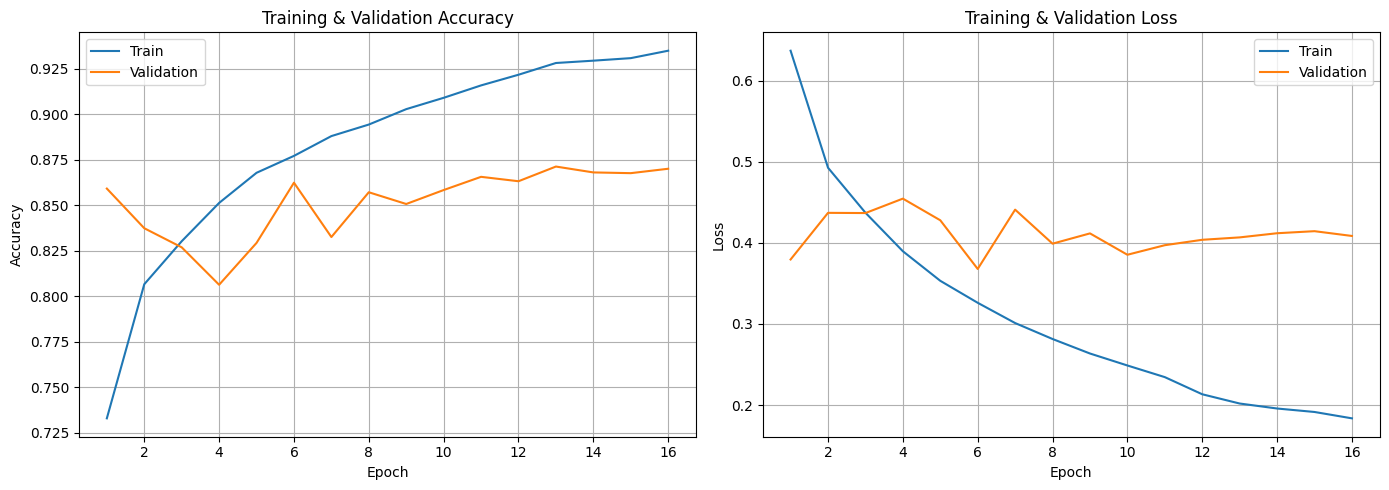

In [49]:
# In ra quá trình huấn luyện:
plot_training_history(history_lstm)

## 3.4. Mở block embedding và fine-tunning mô hình:

In [50]:
# Mở block embedding:
model_lstm.layers[0].trainable = True

In [51]:
# Fine-tune thêm 20 epoch:
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm_finetune = model_lstm.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.8890 - loss: 0.2933 - val_accuracy: 0.8523 - val_loss: 0.3927 - learning_rate: 1.0000e-04
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9006 - loss: 0.2664 - val_accuracy: 0.8507 - val_loss: 0.4079 - learning_rate: 1.0000e-04
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 49s 68ms/step - accuracy: 0.9103 - loss: 0.2468 - val_accuracy: 0.8600 - val_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9117 - loss: 0.2409 - val_accuracy: 0.8579 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9155 - loss: 0.2309 - val_accuracy: 0.8567 - val_loss: 0.3900 - learning_rate: 1.0000e-04
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 50s 69ms/step - accuracy: 0.9206 - loss: 0.2201 - val_accuracy: 0.8571 - val_loss: 0.3966 - learning_rate: 1.0000e-04
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/ste

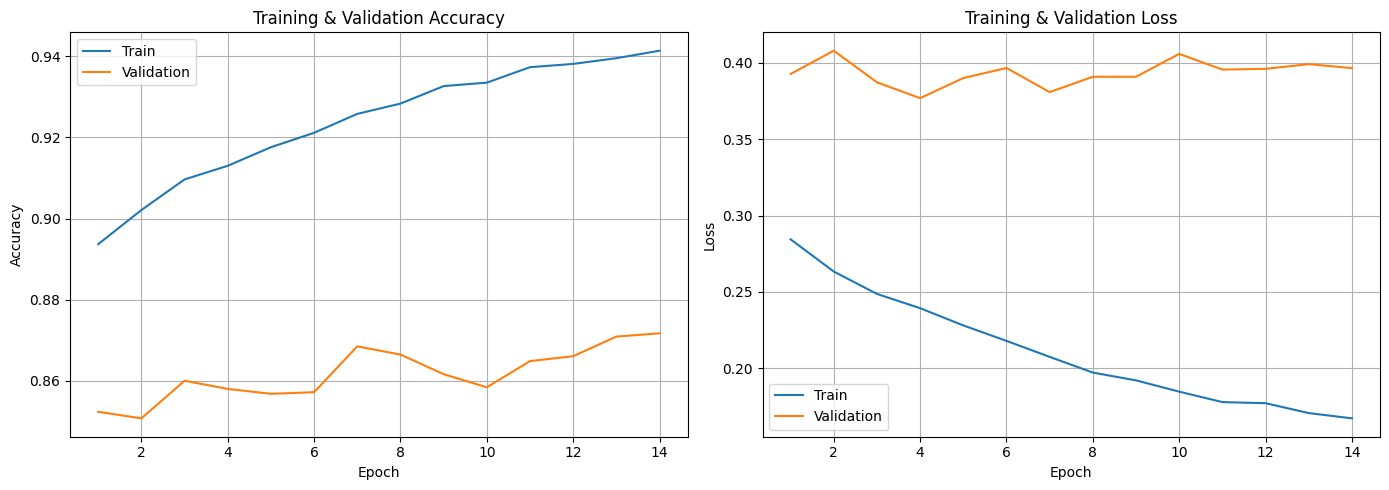

In [52]:
# In ra quá trình huấn luyện:
plot_training_history(history_lstm_finetune)

## 3.5. Đánh giá mô hình trên tập test:

In [53]:
# Đánh giá model trên tập test:
y_pred_lstm = np.argmax(model_lstm.predict(X_test_seq), axis=1)

print(classification_report(y_test, y_pred_lstm, target_names=[
    "Hate Speech", "Offensive", "Neither"
]))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

 Hate Speech       0.29      0.58      0.38       143
   Offensive       0.97      0.87      0.91      1919
     Neither       0.82      0.93      0.87       417

    accuracy                           0.86      2479
   macro avg       0.69      0.79      0.72      2479
weighted avg       0.90      0.86      0.88      2479



In [54]:
report = classification_report(
    y_test,
    y_pred_lstm,
    target_names=class_names,
    digits=4
)

print(report)

                    precision    recall  f1-score   support

       hate_speech     0.2872    0.5804    0.3843       143
offensive_language     0.9651    0.8650    0.9123      1919
           neither     0.8234    0.9281    0.8726       417

          accuracy                         0.8592      2479
         macro avg     0.6919    0.7912    0.7231      2479
      weighted avg     0.9022    0.8592    0.8752      2479



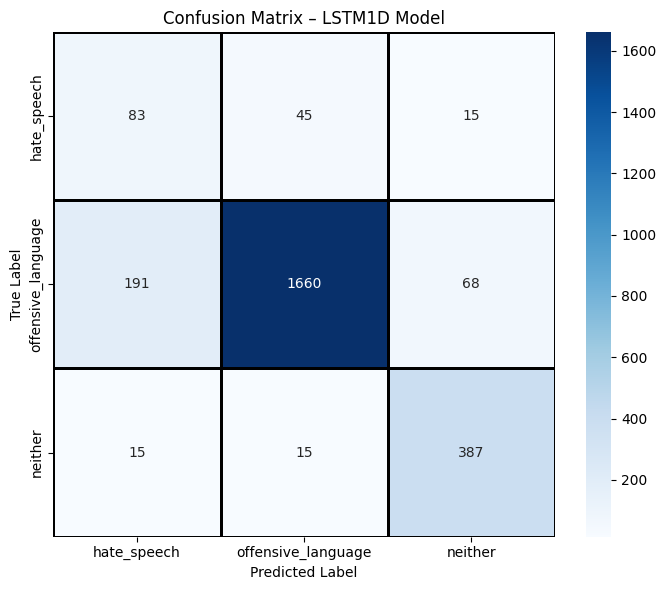

In [55]:
cm = confusion_matrix(y_test, y_pred_lstm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,
    linecolor="black"
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – LSTM1D Model")
plt.tight_layout()
plt.show()

## 3.6. Lưu mô hình về drive:

In [56]:
# Lưu mô hình về drive:
import os
SAVE_DIR = "/content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/LSTM1D_model"
os.makedirs(SAVE_DIR, exist_ok=True)

lstm_model_path = os.path.join(SAVE_DIR, "lstm1d_hate_speech.keras")
model_lstm.save(lstm_model_path)
print(f"LSTM model saved to: {lstm_model_path}")

LSTM model saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/LSTM1D_model/lstm1d_hate_speech.keras


In [57]:
# Lưu tokenizer:
import pickle

tokenizer_path = os.path.join(SAVE_DIR, "tokenizer_lstm1d.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"✅ Tokenizer saved to: {tokenizer_path}")

✅ Tokenizer saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/LSTM1D_model/tokenizer_lstm1d.pkl


In [58]:
# Lưu config preprocessing:
import json

config = {
    "MAX_LEN": MAX_LEN,
    "MAX_VOCAB": MAX_VOCAB,
    "LABEL_MAPPING": {
        "0": "Hate Speech",
        "1": "Offensive",
        "2": "Neither"
    }
}

config_path = os.path.join(SAVE_DIR, "config_lstm1d.json")

with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print(f"✅ Config saved to: {config_path}")

✅ Config saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/LSTM1D_model/config_lstm1d.json


In [59]:
# Test lại model đã lưu:
from tensorflow.keras.models import load_model

loaded_lstm = load_model(lstm_model_path)

loaded_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 16, 100)        │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305,099 (24.05 MB)

 Trainable params: 2,101,699 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,203,400 (16.03 MB)

In [60]:
sample_text = ["you are a stupid, an idiot, a cow in a small circle"]

sample_clean = [clean_text(sample_text[0])]
sample_seq = encode(sample_clean)

pred = loaded_lstm.predict(sample_seq)
pred_label = np.argmax(pred, axis=1)[0]

print("Prediction:", config["LABEL_MAPPING"][str(pred_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
Prediction: Hate Speech


# 4. Mô hình Bi-directional LSTM (LSTM hai chiều):

## 4.1. Tiền xử lý dữ liệu:

- Ta giữ nguyên tiền xử lý như trước.

In [61]:
# Kiểm tra lại dữ liệu đầu vào:
print("Shapes: ", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)
print("Train label distribution:", np.unique(y_train, return_counts=True))
print("Validation label distribution:", np.unique(y_val, return_counts=True))
print("Test label distribution:", np.unique(y_test, return_counts=True))

Shapes:  (46056, 16) (2478, 16) (2479, 16)
Train label distribution: (array([0, 1, 2]), array([15352, 15352, 15352]))
Validation label distribution: (array([0, 1, 2]), array([ 143, 1919,  416]))
Test label distribution: (array([0, 1, 2]), array([ 143, 1919,  417]))


## 4.2. Xây dựng mô hình Bidirectional LSTM:

In [62]:
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout

In [63]:
model_bilstm = Sequential([
    Embedding(
        input_dim=MAX_VOCAB,
        output_dim=EMB_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),

    Bidirectional(
        LSTM(
            128,
            return_sequences=False,
            dropout=0.3,
            recurrent_dropout=0.2
        )
    ),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 4.3. Huấn luyện model đợt 1:

In [64]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0
)

model_bilstm.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_bilstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,976,000 (7.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,976,000 (7.54 MB)

In [65]:
history_bilstm = model_bilstm.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.6906 - loss: 0.7043 - val_accuracy: 0.8503 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 2/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.8146 - loss: 0.4671 - val_accuracy: 0.8406 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 3/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.8484 - loss: 0.3923 - val_accuracy: 0.8293 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 4/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.8727 - loss: 0.3313 - val_accuracy: 0.8632 - val_loss: 0.3810 - learning_rate: 0.0010
Epoch 5/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.8979 - loss: 0.2786 - val_accuracy: 0.8600 - val_loss: 0.3939 - learning_rate: 0.0010
Epoch 6/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.9064 - loss: 0.2467 - val_accuracy: 0.8491 - val_loss: 0.4304 - learning_rate: 0.0010
Epoch 7/30
720/720 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.9

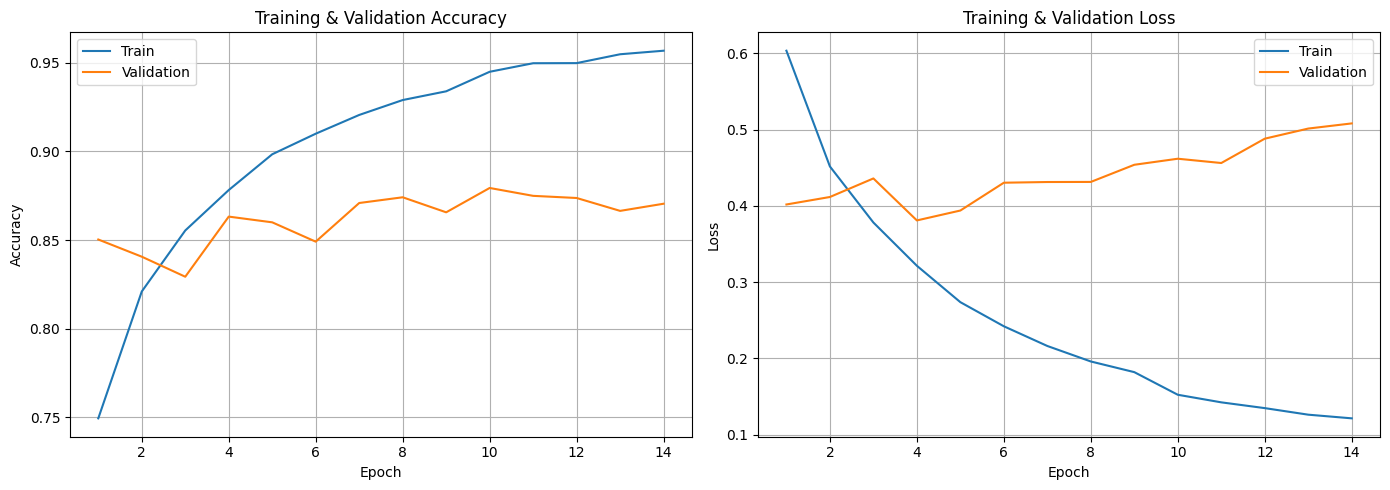

In [66]:
# In ra quá trình huấn luyện:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend(["Train", "Validation"])
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend(["Train", "Validation"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_bilstm)

## 4.4. Mở block embedding và fine-tune lần 2:

In [67]:
# Mở block embedding:
model_bilstm.layers[0].trainable = True

In [68]:
model_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
# Train thêm 20 epoch:
history_bilstm_finetune = model_bilstm.fit(
    X_train_seq,
    y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 92s 120ms/step - accuracy: 0.9025 - loss: 0.2648 - val_accuracy: 0.8592 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 85s 118ms/step - accuracy: 0.9120 - loss: 0.2427 - val_accuracy: 0.8608 - val_loss: 0.3942 - learning_rate: 1.0000e-04
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 88s 122ms/step - accuracy: 0.9165 - loss: 0.2243 - val_accuracy: 0.8483 - val_loss: 0.4229 - learning_rate: 1.0000e-04
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 86s 120ms/step - accuracy: 0.9257 - loss: 0.2061 - val_accuracy: 0.8620 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 87s 121ms/step - accuracy: 0.9292 - loss: 0.1942 - val_accuracy: 0.8604 - val_loss: 0.4143 - learning_rate: 1.0000e-04
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 140s 119ms/step - accuracy: 0.9372 - loss: 0.1780 - val_accuracy: 0.8511 - val_loss: 0.4432 - learning_rate: 1.0000e-04
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 84s 1

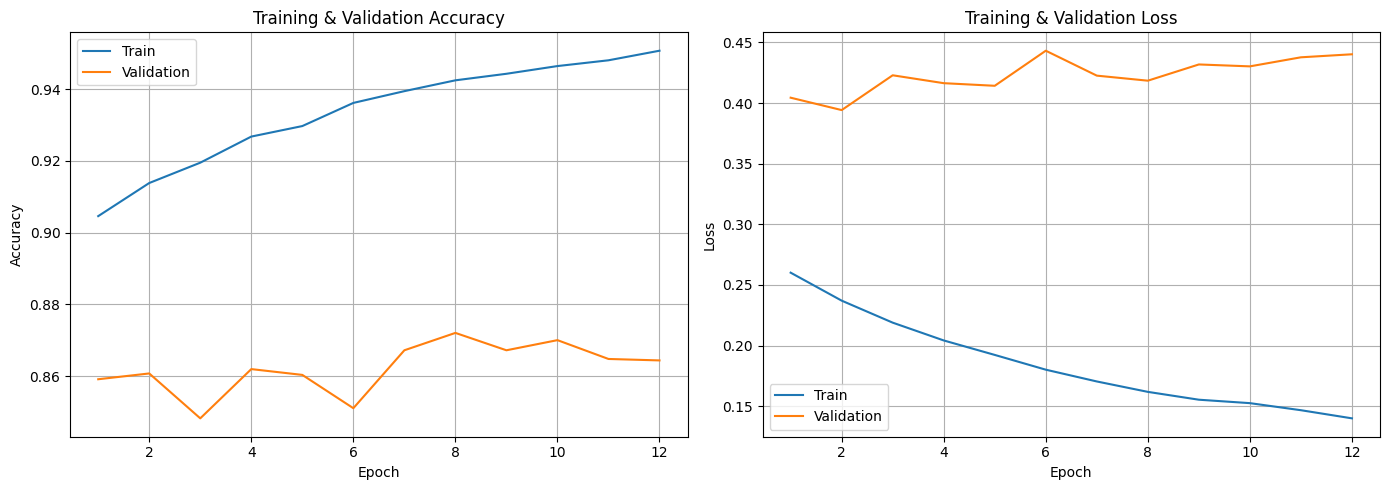

In [70]:
# In ra quá trình huấn luyện:
plot_training_history(history_bilstm_finetune)

## 4.5. Đánh giá model trên tập test:

In [71]:
# Đánh giá model trên tập test:
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test_seq), axis=1)

print(classification_report(y_test, y_pred_bilstm, target_names=[
    "Hate Speech", "Offensive", "Neither"
]))

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
              precision    recall  f1-score   support

 Hate Speech       0.26      0.54      0.35       143
   Offensive       0.96      0.87      0.91      1919
     Neither       0.84      0.90      0.87       417

    accuracy                           0.86      2479
   macro avg       0.69      0.77      0.71      2479
weighted avg       0.90      0.86      0.87      2479



In [72]:
report = classification_report(
    y_test,
    y_pred_bilstm,
    target_names=class_names,
    digits=4
)

print(report)

                    precision    recall  f1-score   support

       hate_speech     0.2628    0.5385    0.3532       143
offensive_language     0.9614    0.8692    0.9130      1919
           neither     0.8359    0.9041    0.8687       417

          accuracy                         0.8560      2479
         macro avg     0.6867    0.7706    0.7116      2479
      weighted avg     0.9000    0.8560    0.8732      2479



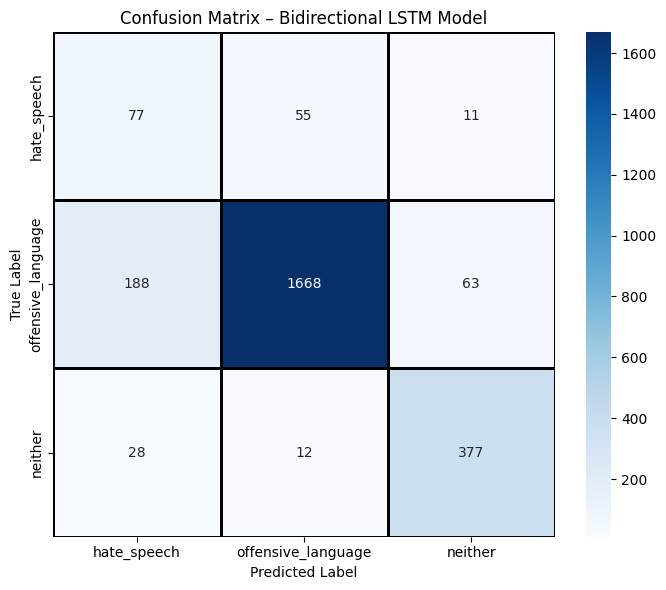

In [73]:
cm = confusion_matrix(y_test, y_pred_bilstm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=1,
    linecolor="black"
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Bidirectional LSTM Model")
plt.tight_layout()
plt.show()

## 4.6. Lưu model về drive:

In [74]:
# Lưu mô hình về drive:
import os
SAVE_DIR = "/content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/BiLSTM_model"
os.makedirs(SAVE_DIR, exist_ok=True)

bilstm_model_path = os.path.join(SAVE_DIR, "bilstm_hate_speech.keras")
model_bilstm.save(bilstm_model_path)
print(f"Bi-LSTM model saved to: {bilstm_model_path}")

Bi-LSTM model saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/BiLSTM_model/bilstm_hate_speech.keras


In [75]:
# Lưu tokenizer:
import pickle

tokenizer_path = os.path.join(SAVE_DIR, "tokenizer_bilstm.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"✅ Tokenizer saved to: {tokenizer_path}")

✅ Tokenizer saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/BiLSTM_model/tokenizer_bilstm.pkl


In [76]:
# Lưu config preprocessing:
import json

config = {
    "MAX_LEN": MAX_LEN,
    "MAX_VOCAB": MAX_VOCAB,
    "LABEL_MAPPING": {
        "0": "Hate Speech",
        "1": "Offensive",
        "2": "Neither"
    }
}

config_path = os.path.join(SAVE_DIR, "config_bilstm.json")

with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print(f"✅ Config saved to: {config_path}")

✅ Config saved to: /content/drive/MyDrive/NLP/Final_Project/Final_RNN_LSTM_Model/hate_speech_models/BiLSTM_model/config_bilstm.json


In [77]:
# Test lại model đã lưu:
from tensorflow.keras.models import load_model

loaded_bilstm = load_model(bilstm_model_path)

loaded_bilstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 16, 100)        │     1,976,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,681,419 (25.49 MB)

 Trainable params: 2,227,139 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,454,280 (16.99 MB)

In [78]:
sample_text = ["you are a stupid, an idiot, a cow in a small circle"]

sample_clean = [clean_text(sample_text[0])]
sample_seq = encode(sample_clean)

pred = loaded_bilstm.predict(sample_seq)
pred_label = np.argmax(pred, axis=1)[0]

print("Prediction:", config["LABEL_MAPPING"][str(pred_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Prediction: Hate Speech
